## "Fun with Spectograms"
Found on: https://gist.github.com/MiguelonGonzalez/00416cbf3d7f3eab204766961cf7c8fb

In [1]:
import numpy as np
from scipy import signal, ndimage
from scipy.interpolate import interp1d

import pywt

import matplotlib.pyplot as plt

from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import time

%matplotlib inline
# plt.rc('figure', figsize=(16, 4))

In [2]:
from glob import glob
import pandas as pd

In [3]:
files = glob('../data/ecg_preprocessed/*.csv')
df = pd.read_csv(files[0])
sampling_frequency = 1000

C:\Users\Admin\AppData\Local\Temp\ipykernel_17140\4174140950.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(files[0])


In [4]:
data = df['signal']

In [5]:
n_samples = len(data)
total_duration = n_samples / sampling_frequency
sample_times = np.linspace(0, total_duration, n_samples)

In [6]:
print (n_samples)

8692000


## Functions

### For comparison - the Short Time Fourier Transform Spectrogram

In [7]:
def stft_gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, detrend=True, normalize=True):
# modified from: https://github.com/drammock/spectrogram-tutorial/blob/master/spectrogram.ipynb
    
    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8.
    
    ###########################################################################
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    ###########################################################################
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = signal.gaussian(window_nsamp, window_sigma)
    
    ###########################################################################
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    ###########################################################################
    # compute the power spectral density
    freqs, times, power = signal.spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='spectrum', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    return power, times, freqs


### Continuous Wavelet Transform Spectrogram

In [8]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif

### Cross Wavelet Transform Spectrogram

In [9]:
def xwt_spectrogram(x1, x2, fs, nNotes=12, detrend=True, normalize=True):
    
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2),   "error: arrays not same size"
    
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x1 = signal.detrend(x1,type='linear')
        x2 = signal.detrend(x2,type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef1, freqs1=pywt.cwt(x1,scales,'cmor1.5-1.0')
    coef2, freqs2=pywt.cwt(x2,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # Calculates the cross CWT of xs1 and xs2.
    coef12 = coef1 * np.conj(coef2)

    ###########################################################################
    # power
    power = np.abs(coef12)

    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif



### Cross Wavelet Transform Phase

In [10]:
def xwt_phase(x1, x2, fs, nNotes=12, detrend=True, normalize=True):
    
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2),   "error: arrays not same size"
    
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x1 = signal.detrend(x1,type='linear')
        x2 = signal.detrend(x2,type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef1, freqs1=pywt.cwt(x1,scales,'cmor1.5-1.0')
    coef2, freqs2=pywt.cwt(x2,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # Calculate the cross transform of xs1 and xs2.
    coef12 = coef1 * np.conj(coef2)

    phase = np.angle(coef12)

    # smooth a bit
    phase = ndimage.gaussian_filter(phase, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return phase, times, frequencies, coif



### Cross Wavelet Transform Coherence

In [11]:
def xwt_coherence(x1, x2, fs, nNotes=12, detrend=True, normalize=True):
    
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2),   "error: arrays not same size"
    
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x1 = signal.detrend(x1,type='linear')
        x2 = signal.detrend(x2,type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef1, freqs1=pywt.cwt(x1,scales,'cmor1.5-1.0')
    coef2, freqs2=pywt.cwt(x2,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # Calculates the cross transform of xs1 and xs2.
    coef12 = coef1 * np.conj(coef2)

    ###########################################################################
    # coherence
    scaleMatrix = np.ones([1, N]) * scales[:, None]
    S1 = ndimage.gaussian_filter((np.abs(coef1)**2 / scaleMatrix), sigma=2)
    S2 = ndimage.gaussian_filter((np.abs(coef2)**2 / scaleMatrix), sigma=2)
    S12 = ndimage.gaussian_filter((np.abs(coef12 / scaleMatrix)), sigma=2)
    WCT = S12**2 / (S1 * S2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return WCT, times, frequencies, coif



### A Plotting Function

In [12]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    ax.plot(times,coif)
    ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

## Test on some data

In [13]:
plt.rcParams['figure.figsize'] = (16, 6)

### STFT Spectrogram

0.05


C:\Users\Admin\AppData\Local\Temp\ipykernel_23784\527428414.py:27: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  window = signal.gaussian(window_nsamp, window_sigma)


6.321617603302002


C:\Users\Admin\AppData\Local\Temp\ipykernel_23784\983676038.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


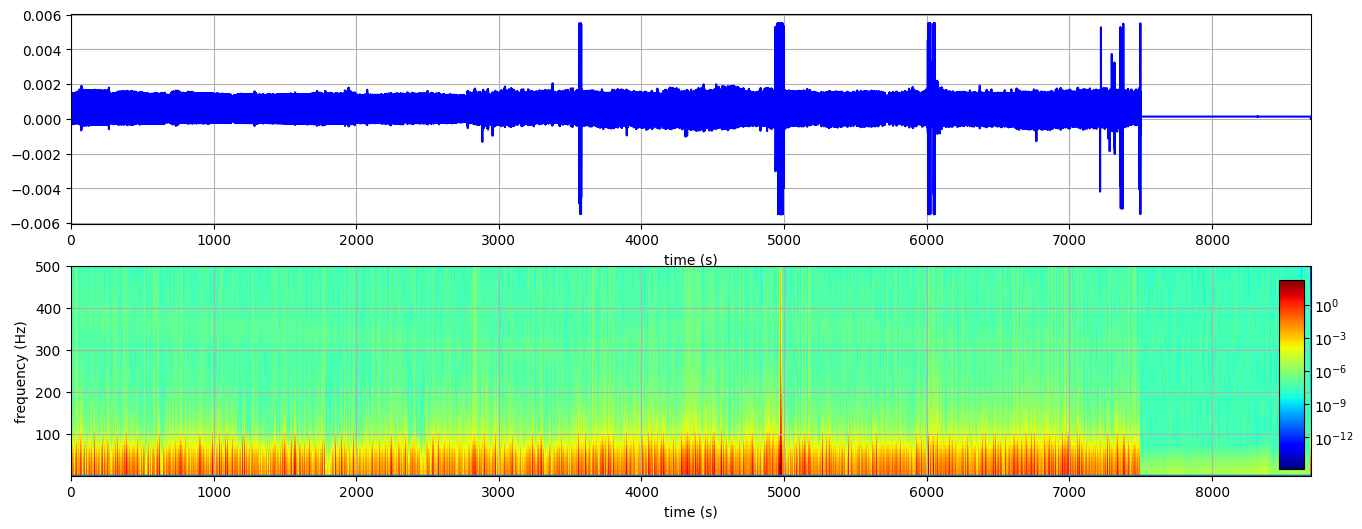

In [14]:
###########################################################################
# calculate spectrogram

wLen = 50/sampling_frequency
print(wLen)

t0 = time.time()
power, times, frequencies = stft_gaussian_spectrogram(data, sampling_frequency, window_dur=wLen)
print (time.time()-t0)
coif = np.zeros(times.shape)

###########################################################################
# plot

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')
ax1.grid(True)

spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax2.set_ylim(0, 0.5*sampling_frequency)
ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)')

ax2.grid(True)

# ax2.set_yscale('log')


### Continuous Wavelet Transform

In [16]:
plt.rcParams['figure.figsize'] = (16, 6)

###########################################################################
# calculate spectrogram

t0 = time.time()
power, times, frequencies, coif = cwt_spectrogram(data, sampling_frequency, nNotes=24)
print (time.time()-t0)


###########################################################################
# plot

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')
ax1.set_ylim(-np.abs(data).max()*1.2,np.abs(data).max()*1.2)
ax1.grid(True)
# ax1.axis('off')
spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax2.set_ylim(0, 0.5*sampling_frequency)
ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)');

ax2.grid(True)

# ax2.set_yscale('log')
plt.savefig('wave.png')

KeyboardInterrupt: 

### Practice changing the x-axis units and interpolating

In [18]:
###########################################################################
# calculate spectrogram

t0 = time.time()
power, times, frequencies, coif = cwt_spectrogram(data, sampling_frequency, nNotes=24)
print (time.time()-t0)


###########################################################################
# plot

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, data, color='b')

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)

spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
# ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)')

ax2.grid(True)

# ax2.set_yscale('log')


###########################################################################
# plot spectrogram again but ...
# change x axis to new units and interpolate spectrum to match on equally spaced grid
###########################################################################

# fig, (ax2) = plt.subplots(1, 1)
fig, (ax1, ax2) = plt.subplots(2, 1)

depths = np.sqrt(times)

t2d = interp1d(times,depths,kind='cubic')
d2t = interp1d(depths,times,kind='cubic')

nFreq = len(frequencies)
nNew = 128
lindepths = np.linspace(depths.min(),depths.max(),nNew)
times2 = d2t(lindepths)

ZZ = np.zeros((nFreq,nNew))
for i in range(nFreq):
    fZZi = interp1d(times,power[i,:],kind='cubic')
    ZZ[i,:] = fZZi(times2)
fcoif = interp1d(times,coif,kind='cubic')
coif2 = fcoif(times2)

# ZZ = ndimage.gaussian_filter(ZZ, sigma=2)

ax1.plot(depths, data, color='b')

ax1.set_xlim(0, depths.max())
ax1.set_xlabel('depth')

ax1.grid(True)

spectrogram_plot(ZZ, lindepths, frequencies, coif2, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.grid(True)
ax2.set_yscale('log')
ax2.set_xlabel('depth (m)')
ax2.set_ylabel('frequency (Hz)')

### Cross Wavelet Transform

In [ ]:
plt.rcParams['figure.figsize'] = (16, 8)

In [ ]:
# make some bad data to compre to

noise = np.random.randn(len(data))*data.max()/100
bad_data = np.copy(data)
# bad_data = np.roll(bad_data,0)
bad_data[500:700] = np.roll(bad_data[500:700],100)

bad_data[200:300] = bad_data[200:300]+noise[200:300]/5
bad_data[900:] = bad_data[900:]+noise[900:]

0.5294685363769531


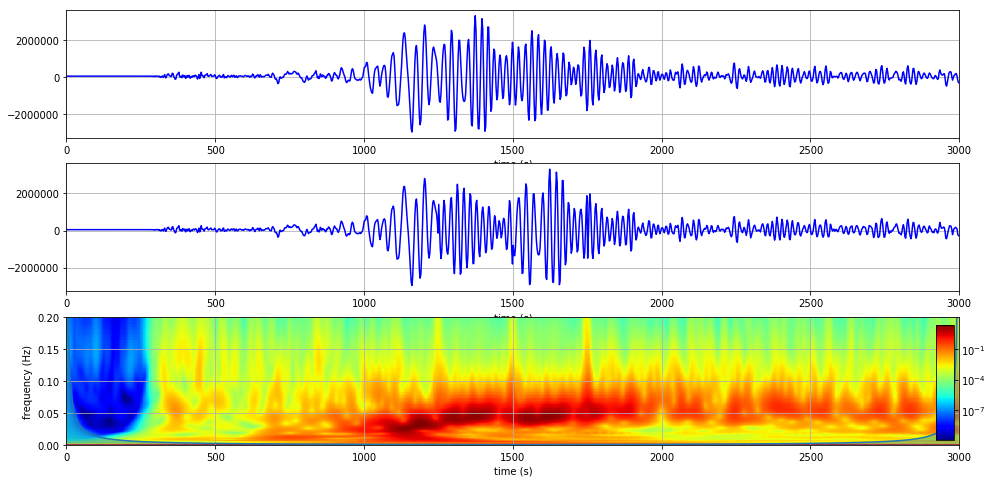

In [ ]:
###########################################################################
# calculate spectrogram

t0 = time.time()
power, times, frequencies, coif = xwt_spectrogram(data, bad_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


################################################################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

################################################################
ax1.plot(sample_times, data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)
################################################################
ax2.plot(sample_times, bad_data, color='b');

ax2.set_xlim(0, total_duration)
ax2.set_xlabel('time (s)')

ax2.grid(True)
################################################################

spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax3)
ax3.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
ax3.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('frequency (Hz)')

ax3.grid(True)
# ax3.set_yscale('log')

### Cross Wavelet Coherence

0.5753791332244873


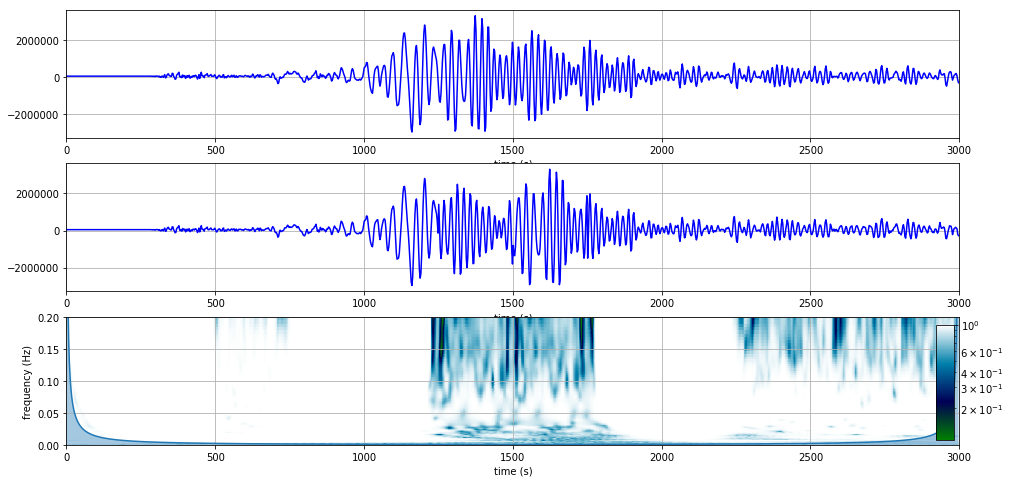

In [ ]:
###########################################################################
# calculate spectrogram

t0 = time.time()
coherence, times, frequencies, coif = xwt_coherence(data, bad_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


################################################################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

################################################################
ax1.plot(sample_times, data, color='b')

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)
################################################################
ax2.plot(sample_times, bad_data, color='b')

ax2.set_xlim(0, total_duration)
ax2.set_xlabel('time (s)')

ax2.grid(True)
################################################################

spectrogram_plot(coherence, times, frequencies, coif, cmap='ocean', norm=LogNorm(), ax=ax3)
ax3.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
ax3.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('frequency (Hz)')

ax3.grid(True)
# ax3.set_yscale('log')

### Cross Wavelet Phase

0.5037808418273926


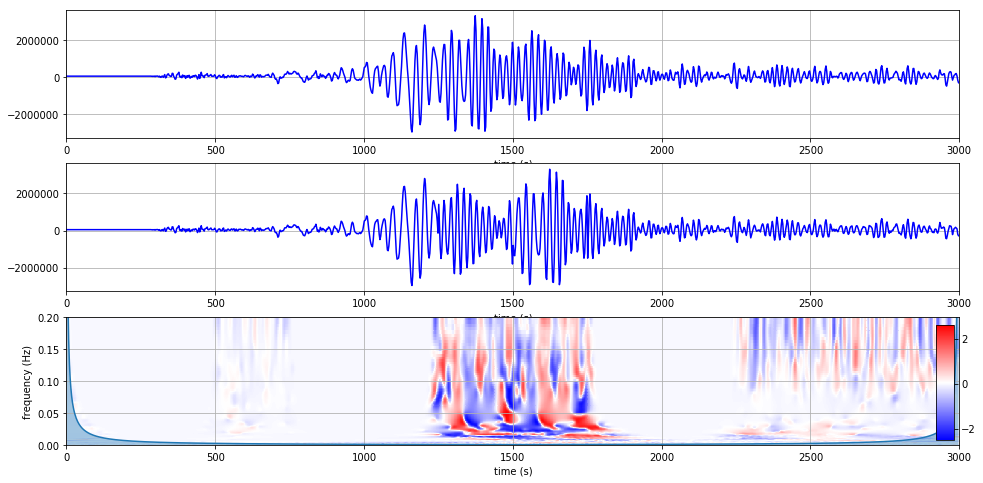

In [ ]:
###########################################################################
# calculate spectrogram

t0 = time.time()
phase, times, frequencies, coif = xwt_phase(data, bad_data, sampling_frequency, nNotes=24)
print (time.time()-t0)


################################################################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(sample_times, data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')

ax1.grid(True)


ax2.plot(sample_times, bad_data, color='b');

ax2.set_xlim(0, total_duration)
ax2.set_xlabel('time (s)')

ax2.grid(True)
################################################################

spectrogram_plot(phase, times, frequencies, coif, cmap='bwr', norm=Normalize(), ax=ax3)
ax3.set_xlim(0, total_duration)
# ax.set_ylim(0, 0.5*sampling_frequency)
ax3.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('frequency (Hz)')

ax3.grid(True)
# ax3.set_yscale('log')